<h1>Final Year Project - The Third Eye </h1>
Done by: See Zhuo Yi Joey (2011927), Liu Zhen (2021250), Koh Hui Lyn (2021672) and Ang Jun Hoa (2040295)
<br/>Project Aim: Using computer vision to aid coach’s analysis of a bowler’s performance by producing consistent and accurate intelligent analysis.
<br/>Modules Required: MediaPipe, OpenCV


<h2>Installing Required Packages</h2>

In [1]:
# pip install mediapipe
# pip install opencv-python

<h2>Importing</h2>

In [2]:
import cv2
import time
import math as m
import mediapipe as mp
import os
import datetime

<h2>Functions</h2>

In [3]:
# Find Distance between 2 points
def findDistance(x1, y1, x2, y2):
    dist = m.sqrt((x2-x1)**2+(y2-y1)**2)
    return dist

# Calculate angle
def findAngle(x1, y1, x2, y2):
    theta = m.acos((y2 -y1)*(-y1) / (m.sqrt((x2 - x1)**2 + (y2 - y1)**2) * y1))
    degree = int(180/m.pi)*theta
    return degree

# Calculate difference of x-coordinate of two points
def findX(x_knee,x_hand):
  X = x_hand - x_knee
  return X


<h2>Utils</h2>

In [4]:
# Font (For OpenCV Video)
font = cv2.FONT_HERSHEY_SIMPLEX

# Colors
blue = (255, 127, 0)
red = (50, 50, 255)
green = (127, 255, 0)
dark_blue = (127, 20, 0)
light_green = (127, 233, 100)
yellow = (0, 255, 255)
pink = (255, 0, 255)

In [5]:
# Using Mediapipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Choose which video to use
# ((For webcam input replace file name with 0))
file_name = './videos/don/don9.mp4'
cap = cv2.VideoCapture(file_name)

# CV2  properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_size = (width, height)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Initialize video writer. might take a look at this again.
# video_output = cv2.VideoWriter('test_{0}.mp4'.format(datetime.datetime.now().strftime("%d-%m-%Y")), fourcc, fps, frame_size)
video_output = cv2.VideoWriter("don9.mp4", fourcc, fps, frame_size)

<h2>Main Code</h2>

In [6]:
import pandas as pd
feetInfo = pd.DataFrame(columns=["Frame","LH_X","LI_X"])

In [7]:
print('Starting...')
steps = 0
stage = None
max_dis = 0
access = 1
velo = 0
ball_release = None
maxFeetLength = 0
currentFrame= 0
currentframenumber=dict.fromkeys(["Angle1","Angle2","Angle3","Angle4","Angle5","Release"])
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
while cap.isOpened():
    # Capture frames
    success, image = cap.read()
    if not success:
        print("No frames left to process!!!")
        break
    # Get fps, height and width
    fps = cap.get(cv2.CAP_PROP_FPS)
    h, w = image.shape[:2]
    # Convert the BGR image to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Process the frame with Mediapipe Pose
    keypoints = pose.process(image)
    # Convert the image back to BGR
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    #============ Getting landmarks ============
    lm = keypoints.pose_landmarks
    lmPose = mp_pose.PoseLandmark

    # For Angle Component 
    l_shldr_x = int(lm.landmark[lmPose.LEFT_SHOULDER].x * w)
    l_shldr_y = int(lm.landmark[lmPose.LEFT_SHOULDER].y * h)
    r_shldr_x = int(lm.landmark[lmPose.RIGHT_SHOULDER].x * w)
    r_shldr_y = int(lm.landmark[lmPose.RIGHT_SHOULDER].y * h)
    l_ear_x = int(lm.landmark[lmPose.LEFT_EAR].x * w)
    l_ear_y = int(lm.landmark[lmPose.LEFT_EAR].y * h)
    l_hip_x = int(lm.landmark[lmPose.LEFT_HIP].x * w)
    l_hip_y = int(lm.landmark[lmPose.LEFT_HIP].y * h)

    # Ankles for feet distance calculation
    l_ank_x = int(lm.landmark[lmPose.LEFT_ANKLE].x * 100)
    l_ank_y = int(lm.landmark[lmPose.LEFT_ANKLE].y * 100)
    r_ank_x = int(lm.landmark[lmPose.RIGHT_ANKLE].x * 100)
    r_ank_y = int(lm.landmark[lmPose.RIGHT_ANKLE].y * 100)

    r_ind_x = int(lm.landmark[lmPose.RIGHT_INDEX].x * 100)
    r_ind_y = int(lm.landmark[lmPose.RIGHT_INDEX].y * 100)
    r_heel_x = int(lm.landmark[lmPose.RIGHT_HEEL].x * 100)
    r_heel_y = int(lm.landmark[lmPose.RIGHT_HEEL].y * 100)

    l_ind_x = int(lm.landmark[lmPose.LEFT_INDEX].x * 100)
    l_ind_y = int(lm.landmark[lmPose.LEFT_INDEX].y * 100)
    l_heel_x = int(lm.landmark[lmPose.LEFT_HEEL].x * 100)
    l_heel_y = int(lm.landmark[lmPose.LEFT_HEEL].y * 100)

    if (cap.get(cv2.CAP_PROP_POS_FRAMES) < 20):
        feetLength = r_ind_x - r_heel_x
        if feetLength > maxFeetLength:
            maxFeetLength = feetLength

    # For Timing Component
    r_wrist_x = int(lm.landmark[lmPose.RIGHT_WRIST].x * w)
    r_knee_x = int(lm.landmark[lmPose.RIGHT_KNEE].x * w)
    l_knee_x = int(lm.landmark[lmPose.LEFT_KNEE].x * w)

    #============ Functions ============

    # Check for Camera Alignment to be in Proper Sideview
    offset = findDistance(l_shldr_x, l_shldr_y, r_shldr_x, r_shldr_y)
    if offset < 100:
        cv2.putText(image, str(int(offset)) + ' Aligned', (w - 150, 30), font, 0.9, green, 2)
    else:
        cv2.putText(image, str(int(offset)) + ' Not Aligned', (w - 150, 30), font, 0.9, red, 2)

    feetDist = findDistance(l_ank_x, l_ank_y, r_ank_x, r_ank_y)

    # Steps Counter (To be improved - ie Thresholds improvements)
    if steps < 5:
        if feetDist > maxFeetLength and stage == 'up':
            steps += 1
            stage = "down"
        elif feetDist < maxFeetLength:
            stage = "up"

    # Timing Component
    if feetDist > 2*maxFeetLength:
        currentFrame = cap.get(cv2.CAP_PROP_POS_FRAMES)
        pre = currentFrame - 4
        # Calculate Velocity with this frame and 4 frames before
        velo = abs(((l_heel_x - feetInfo["LH_X"][pre])/(currentFrame-pre)))
        if velo == 0 and access == 1:
            access = 0
            ball_train_feet_dis = findX(r_knee_x, r_wrist_x)
            ball_slide_feet_dis = findX(l_knee_x, r_wrist_x)
            if ball_train_feet_dis < 0:
                ball_release = "Late"
            elif ball_train_feet_dis > 0 and ball_slide_feet_dis < 0:
                ball_release = "Traditional"
            elif ball_slide_feet_dis > 0:
                ball_release = "Early"
  
    # Append to array
    feetStuff = {"Frame": cap.get(cv2.CAP_PROP_POS_FRAMES)+1, "LH_X":l_heel_x,"LI_X":l_ind_x,"Velocity": velo}
    feetInfo = feetInfo.append(feetStuff, ignore_index=True)

    # Calculate torso and neck angles
    neck_inclination = findAngle(l_shldr_x, l_shldr_y, l_ear_x, l_ear_y)
    torso_inclination = findAngle(l_hip_x, l_hip_y, l_shldr_x, l_shldr_y)

    #============ Annotations onto video ============
    # # Draw landmarks
    # cv2.circle(image, (l_shldr_x, l_shldr_y), 7, yellow, -1)
    # cv2.circle(image, (l_ear_x, l_ear_y), 7, yellow, -1)
    # cv2.circle(image, (l_shldr_x, l_shldr_y - 100), 7, yellow, -1)
    # # Right shoulder is pink ball
    # cv2.circle(image, (r_shldr_x, r_shldr_y), 7, pink, -1)
    # cv2.circle(image, (l_hip_x, l_hip_y), 7, yellow, -1)
    # cv2.circle(image, (l_hip_x, l_hip_y - 100), 7, yellow, -1)

    # Display the skeleton
    mp_drawing.draw_landmarks(
        image,
        keypoints.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    # Text for Neck/Torso Angle, Feet distance & Steps
    # angle_text_string = 'Neck : ' + str(int(neck_inclination)) + '  Torso : ' + str(int(torso_inclination)) + ' Feet distance: '+ str(int(feetDist)) + ' Steps: '+ str(int(steps))  + 'Release: '+ str(ball_release)
    angle_text_string = 'Frame: '+str(cap.get(cv2.CAP_PROP_POS_FRAMES)) +' Feet distance: '+ str(int(feetDist)) + ' Steps: '+ str(int(steps))  + 'Release: '+ str(ball_release) + 'Velocity'+ str(velo)
    cv2.putText(image, angle_text_string, (10, 50), font, 0.8, dark_blue, 4)

    # # Display angles on the annotation
    # cv2.putText(image, str(int(neck_inclination)), (l_shldr_x + 10, l_shldr_y), font, 1.2, pink, 2)
    # cv2.putText(image, str(int(torso_inclination)), (l_hip_x + 10, l_hip_y), font, 1.2, pink, 2)

    # # Join landmarks
    # cv2.line(image, (l_shldr_x, l_shldr_y), (l_ear_x, l_ear_y), green, 4)
    # cv2.line(image, (l_shldr_x, l_shldr_y), (l_shldr_x, l_shldr_y - 100), green, 4)
    # cv2.line(image, (l_hip_x, l_hip_y), (l_shldr_x, l_shldr_y), green, 4)
    # cv2.line(image, (l_hip_x, l_hip_y), (l_hip_x, l_hip_y - 100), green, 4)
    # if torso_inclination >= 43:
    #     detectedFrame = cap.get(cv2.CAP_PROP_POS_FRAMES)
    #     currentframenumber.append(detectedFrame-3)
    # # Write frames.
    # video_output.write(image)

    # Write frames.
    video_output.write(image)
print('Video is done!')
cap.release()
video_output.release()

Starting...
No frames left to process!!!
Video is done!


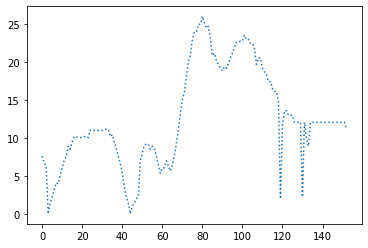

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.plot(feetInfo["MaxFeetDist"], linestyle = 'dotted')
plt.show()

In [8]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(feetInfo)

     Frame   LH_X   LI_X   LH_Y   LI_Y  Velocity
0      2.0   38.0  172.0  355.0  206.0       0.0
1      3.0   49.0  178.0  355.0  206.0       0.0
2      4.0   54.0  182.0  358.0  207.0       0.0
3      5.0   64.0  185.0  358.0  209.0       0.0
4      6.0   75.0  190.0  359.0  212.0       0.0
5      7.0   84.0  195.0  361.0  215.0       0.0
6      8.0   93.0  201.0  364.0  219.0       0.0
7      9.0  103.0  206.0  368.0  221.0       0.0
8     10.0  112.0  213.0  371.0  223.0       0.0
9     11.0  119.0  218.0  374.0  224.0       0.0
10    12.0  127.0  221.0  377.0  226.0       0.0
11    13.0  132.0  225.0  379.0  227.0       0.0
12    14.0  136.0  227.0  382.0  228.0       0.0
13    15.0  138.0  227.0  382.0  227.0       0.0
14    16.0  140.0  225.0  384.0  226.0       0.0
15    17.0  141.0  225.0  384.0  226.0       0.0
16    18.0  142.0  222.0  384.0  223.0       0.0
17    19.0  144.0  198.0  384.0  210.0       0.0
18    20.0  144.0  180.0  384.0  231.0       0.0
19    21.0  144.0  1

# Re-Reading Analysed Video for Screenshotting


In [ ]:
path ='./Analysedphoto'
isExist = os.path.exists(path)

if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(path)
  print("Analysedphoto folder is created!")

cap=cv2.VideoCapture('test_12-07-2022.mp4')
ret,frame= cap.read()
x=0
bool=True
testing=[212.0]
frameLen=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
while bool:
    for i in range(0,frameLen,1):
        if x>=len(testing):
            bool=False
            break
        # print("iv1 ", i)
        # print(x<len(currentframenumber))
        ret,frame= cap.read()
        if i== testing[x]:
            print(cap.get(cv2.CAP_PROP_POS_FRAMES))
            # print("iv2", i)
            x=x+1
            print(x)
            cv2.imwrite("Analysedphoto/frame%d.jpg" % i, frame)     # save frame as JPEG file      
            print('Read a new frame: ', ret)
        

214.0
1
Read a new frame:  True
